# Basic setting

In [1]:
import os
import sys
import pandas as pd
# options for display setting
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False) 
import numpy as np
import dbfread
from dbfread import DBF
import dbf
from glob import glob 
from sklearn.preprocessing import OneHotEncoder


## check 
import datetime 
from datetime import datetime
import time


import csv
import pickle

from scipy.interpolate import interp1d
import scipy.stats as stats

import dbfread
from dbfread import DBF
import dbf
from glob import glob 

from collections import Counter
from tqdm import tqdm
import plotly.express as px


import matplotlib.pyplot as plt

import plotly as py
from plotly import graph_objs as go
from plotly.subplots import make_subplots
import seaborn as sns

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()


pd.options.mode.chained_assignment = None

import utils
from utils.model_utils import eda_mean, eda_count_peaks, eeg_mean_bandpower, temp_mean, signal_interp, label_bin, acc_mag_mean, ecg_hrv, ecg_hr, max_audio, min_audio, std_audio, mean_audio


from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import StratifiedShuffleSplit, LeaveOneGroupOut
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, precision_score, recall_score

from sklearn.model_selection import train_test_split


# Data Load

Once you load data, following feature extraction is required. 
Because it requires some time to extract features according to the environments, please use a code to save the extracted features once you decide your windows for feature extraction. 
Ours are extracted based on the basic settings below. 


In [2]:
DATASET = '/Users/iduli/Desktop/Ch2_25_Scientific_Data/Final/Dataset_publish/K-EmoWorker' # change the dataset link

LABELS = os.path.join(DATASET, 'LABELS')
label = os.path.join(LABELS, 'label.pkl')
with open(label, 'rb') as f:
  LABELS = pickle.load(f)

SENSOR_PATH = os.path.join(DATASET, 'SENSORS')
sensors = os.path.join(SENSOR_PATH, 'sensors.pkl')
with open(sensors, 'rb') as f:
  SENSORS = pickle.load(f)

audio = os.path.join(SENSOR_PATH, 'audio.pkl')
with open(audio, 'rb') as f:
  AUDIO = pickle.load(f)

META = os.path.join(DATASET, 'META')
general_information = 'meta.csv'
meta = pd.read_csv(os.path.join(META, general_information), index_col=None)
video = os.path.join(SENSOR_PATH, 'video.pkl')
with open(video, 'rb') as f:
  VIDEO = pickle.load(f)


# 1. Check time-sync 

In [ ]:
variable_names = [
    "PNUM", "ECG_HRV", "ECG_HR", "EDA_MEAN", "EDA_PEAK", "TEMP_MEAN",
    "ACC_MEAN", "EEG_MEAN_BANDPOWER", "AUDIO_CUSTOMER", "AUDIO_WORKER", "LABEL"
    "VIDEO"
    ]

for name in variable_names:
    globals()[name] = pd.DataFrame()

eeg_sampling_rate = 256

# audio 만 추가 되면 됨 
for i, sessions in LABELS.items():
    order_type = meta.loc[meta["Pnum"] == i, "order_type"].values[0]
    c1, c2, c3 = 0, (1 if order_type == 1 else 2), (2 if order_type == 1 else 1)
       
    for session in sessions.keys():
        print('pnum:', i, 'session:', session) 
        '''Load data'''
        sensor_keys = ['e4_eda', 'e4_temp', 'e4_acc', 'polar_rr', 'polar_hr', 'muse']
        sensor_data = {key: pd.DataFrame(SENSORS[i][session][key]) for key in sensor_keys}
        label_keys = ['stress', 'arousal', 'valence', 'suppression']
        label_data = {key: pd.DataFrame(LABELS[i][session][key]) for key in label_keys}

        video_data = VIDEO[i][session] 
        
        audio_keys = {1: 'worker', 2: 'customer'}
        audio_data = {
            audio_keys[key]: pd.DataFrame(AUDIO[i][session][key]).rename(columns=lambda x: f"{audio_keys[key]}_{x}" if x != 'Timestamp' else x)
            for key in audio_keys
            }        
        '''preprocessing '''
        # MUSE_interpolation 
        sensor_data['muse'] = signal_interp(sensor_data['muse'], eeg_sampling_rate)

        '''Data crop'''
        #Time stamp 확인 코드
        timestamps = {}
        for key, df in {**sensor_data, **label_data, **audio_data, "video": video_data}.items():
            #print(key)
            #ts_list = df['Timestamp'].tolist() 
            if isinstance(df, pd.DataFrame):
                ts_list = df['Timestamp'].tolist() if 'Timestamp' in df.columns else []
            elif isinstance(df, pd.Series):
                ts_list = df.tolist() if df.name == 'Timestamp' else []
            else:
                ts_list = []
            if ts_list:
                timestamps[key] = ts_list
                #print(f"[{key}] t0 = {ts_list[0]}, t-1 = {ts_list[-1]}, Δ = {ts_list[-1] - ts_list[0]} ms")
            else:
                print(f"[{key}] ⚠️ Timestamp list is empty.")

        # 추가됨 
        # 시작점(t0)과 종료점(t_last) 추출
        start_times = {key: ts[0] for key, ts in timestamps.items() if ts}
        end_times = {key: ts[-1] for key, ts in timestamps.items() if ts}

        # 상대 시간 계산을 위한 가장 이른 시작점
        max_start = max(start_times.values())
        min_end = min(end_times.values())

        # 상대 시작 시간 및 종료 시간 (ms 단위)
        relative_start_times = {key: st - max_start for key, st in start_times.items()}
        relative_end_times = {key: et - max_start for key, et in end_times.items()}

        # y축에 출력할 순서를 위해 정렬
        sorted_keys = sorted(relative_start_times, key=relative_start_times.get)
        sorted_start_vals = [relative_start_times[key] for key in sorted_keys]
        sorted_end_vals = [relative_end_times[key] for key in sorted_keys]

        
        # 시각화
        plt.figure(figsize=(10, 6))

        # 시작점: 파란 원
        plt.scatter(sorted_start_vals, range(len(sorted_keys)), color='blue', marker='o', label='Start')
        # 종료점: 빨간 X
        plt.scatter(sorted_end_vals, range(len(sorted_keys)), color='red', marker='x', label='End')

        # 시작점과 종료점을 연결하는 점선
        for p in range(len(sorted_keys)):
            plt.plot([sorted_start_vals[p], sorted_end_vals[p]], [p, p], color='gray', linestyle='--')

        plt.yticks(range(len(sorted_keys)), sorted_keys)
        plt.xlabel("Relative Time (ms)")
        plt.title("Comparison of Data Stream Start and End Times")
        plt.grid(True)
        plt.legend()

        # 각 점에 절대 시간 주석 추가
        for p, key in enumerate(sorted_keys):
            plt.text(sorted_start_vals[p], p, f" {start_times[key]:.0f}", va='center', fontsize=8, color='blue')
            plt.text(sorted_end_vals[p], p, f" {end_times[key]:.0f}", va='center', fontsize=8, color='red')

        plt.show()



In [4]:
# setting for feature extraction, users can change this 
physi_window = 10
audio_window = 5
acc_window = 5
label_window = 5
slide = 1

eeg_sampling_rate = 256

# 2. Performance evaluation (ML modeling)

## Data Preprocessiong
* data crop 
* apply filter, interpolation  
* feature extraction 
* transform data and build initial dataset in a form of Dataframe for integration 

In [5]:
variable_names = [
    "PNUM", "ECG_HRV", "ECG_HR", "EDA_MEAN", "EDA_PEAK", "TEMP_MEAN",
    "ACC_MEAN", "EEG_MEAN_BANDPOWER", "AUDIO_CUSTOMER", "AUDIO_WORKER", "LABEL"
    # "VIDEO"
    ]

for name in variable_names:
    globals()[name] = pd.DataFrame()

# audio 만 추가 되면 됨 
for i, sessions in LABELS.items():
    order_type = meta.loc[meta["Pnum"] == i, "order_type"].values[0]
    c1, c2, c3 = 0, (1 if order_type == 1 else 2), (2 if order_type == 1 else 1)
       
    for session in sessions.keys():
        print('pnum:', i, 'session:', session) 
        '''Load data'''
        sensor_keys = ['e4_eda', 'e4_temp', 'e4_acc', 'polar_rr', 'polar_hr', 'muse']
        sensor_data = {key: pd.DataFrame(SENSORS[i][session][key]) for key in sensor_keys}
        label_keys = ['stress', 'arousal', 'valence', 'suppression']
        label_data = {key: pd.DataFrame(LABELS[i][session][key]) for key in label_keys}

        video_data = VIDEO[i][session] 
        
        audio_keys = {1: 'worker', 2: 'customer'}
        audio_data = {
            audio_keys[key]: pd.DataFrame(AUDIO[i][session][key]).rename(columns=lambda x: f"{audio_keys[key]}_{x}" if x != 'Timestamp' else x)
            for key in audio_keys
            }        
        '''preprocessing '''
        # MUSE_interpolation 
        sensor_data['muse'] = signal_interp(sensor_data['muse'], eeg_sampling_rate)

        '''Data crop'''
        timestamps = {key: df['Timestamp'].tolist() for key, df in {**sensor_data, **label_data, **audio_data}.items()}
        max_start = max(t[0] for t in timestamps.values() if t)
        min_end = min(t[-1] for t in timestamps.values() if t)
        print('Global time range:', max_start, 'to', min_end, min_end - max_start)

        # 3. 실제 동기화 처리 + 모든 source 고려
        for key, df in {**sensor_data, **label_data, **audio_data}.items():
            time_col = 'Timestamp'
            # 양쪽 조건을 모두 포함시켜야 실제로 겹치는 구간만 남음
            df = df.loc[(df[time_col] >= max_start) & (df[time_col] <= min_end)]                
            if key in sensor_data:
                sensor_data[key] = df
            elif key in label_data:
                label_data[key] = df
            elif key in audio_data:
                audio_data[key] = df

        #feature extraction 
        # E4    
        out_eda_mean = eda_mean(sensor_data['e4_eda'], physi_window, slide) 
        out_eda_peak = eda_count_peaks(sensor_data['e4_eda'], physi_window, slide)
        out_temp_mean = temp_mean(sensor_data['e4_temp'], physi_window, slide)
        out_acc_mag_mean = acc_mag_mean(sensor_data[ 'e4_acc'], acc_window, slide)
        # Polar H10
        out_ecg_hrv = ecg_hrv(sensor_data['polar_rr'], physi_window, slide)
        out_ecg_hr = ecg_hr(sensor_data['polar_hr'], physi_window, slide)
        # MUSE : eeg_mean_bandpower
        out_eeg_meanbp = eeg_mean_bandpower(sensor_data['muse'], sampling_rate=256, window=physi_window, slide=slide, show=False)
        # Audio 
        audio_worker_data = audio_data['worker']
        audio_customer_data = audio_data['customer']   
        out_audio_customer_mean, out_audio_customer_min, out_audio_customer_max, out_audio_customer_std = mean_audio(audio_customer_data, audio_window, slide), min_audio(audio_customer_data, audio_window, slide), max_audio(audio_customer_data, audio_window, slide), std_audio(audio_customer_data, audio_window, slide)
        out_audio_worker_mean, out_audio_worker_min, out_audio_worker_max, out_audio_worker_std = mean_audio(audio_worker_data, audio_window, slide), min_audio(audio_worker_data, audio_window, slide), max_audio(audio_worker_data, audio_window, slide), std_audio(audio_worker_data, audio_window, slide)

        # Labels 
        label_dfs = []
        for label_name in label_keys:
            label_df = label_bin(label_data[label_name], label_name, label_window, slide)
            label_dfs.append(label_df)
            label_df = label_df.rename(columns={'Timestamp': f'{label_name}_Timestamp'})
        label = pd.concat(label_dfs, axis=1)  # 열(Column) 방향으로 결합
        label['pnum'] = i
        label['session'] = c1 if session == 'c1' else (c2 if session == 'c2' else c3)
    
        print('pnum: ', i)
        print('session: ', session)
        print('EDA length: ', len(out_eda_mean))
        print('EEG length: ', len(out_eeg_meanbp))
        print('TEMP length: ', len(out_temp_mean))
        print('ACC length: ', len(out_acc_mag_mean))
        print('ECG HRV length: ', len(out_ecg_hrv))
        print('ECG HR length: ', len(out_ecg_hr))
        print('AUDIO customer length: ', len(out_audio_customer_mean))
        print('AUDIO worker length: ', len(out_audio_worker_mean))
        print('LABEL length: ', len(label))

        min_len = min(len(out_eda_mean), 
                    len(out_temp_mean), 
                    len(out_acc_mag_mean),
                    len(out_eeg_meanbp), 
                    len(out_ecg_hrv), 
                    len(out_ecg_hr),
                    len(out_audio_customer_mean), len(out_audio_customer_std),
                    len(out_audio_worker_mean), len(out_audio_worker_std), 
                    len(label))

        EDA_MEAN = pd.concat([EDA_MEAN, out_eda_mean.iloc[0:min_len]])
        EDA_PEAK = pd.concat([EDA_PEAK, out_eda_peak.iloc[0:min_len]])
        EEG_MEAN_BANDPOWER = pd.concat([EEG_MEAN_BANDPOWER, out_eeg_meanbp.iloc[0:min_len]])
        TEMP_MEAN = pd.concat([TEMP_MEAN, out_temp_mean.iloc[0:min_len]])
        ACC_MEAN = pd.concat([ACC_MEAN, out_acc_mag_mean.iloc[0:min_len]])
        ECG_HRV = pd.concat([ECG_HRV, out_ecg_hrv.iloc[0:min_len]])
        ECG_HR = pd.concat([ECG_HR, out_ecg_hr.iloc[0:min_len]])
        AUDIO_CUSTOMER_add = pd.concat([out_audio_customer_max.iloc[0:min_len], out_audio_customer_min.iloc[0:min_len], out_audio_customer_mean.iloc[0:min_len], out_audio_customer_std.iloc[0:min_len]], axis=1)
        AUDIO_CUSTOMER = pd.concat([AUDIO_CUSTOMER, AUDIO_CUSTOMER_add])
        AUDIO_WORKER_add = pd.concat([out_audio_worker_mean.iloc[0:min_len], out_audio_worker_min.iloc[0:min_len], out_audio_worker_max.iloc[0:min_len], out_audio_worker_std.iloc[0:min_len]], axis=1)
        AUDIO_WORKER = pd.concat([AUDIO_WORKER, AUDIO_WORKER_add])
        LABEL = pd.concat([LABEL, label.iloc[0:min_len]]) 

pnum: 1 session: c1
Global time range: 1671068340898.0 to 1671068585599 244701.0
pnum:  1
session:  c1
EDA length:  235
EEG length:  235
TEMP length:  235
ACC length:  240
ECG HRV length:  234
ECG HR length:  234
AUDIO customer length:  240
AUDIO worker length:  240
LABEL length:  240
pnum: 1 session: c2
Global time range: 1671068810855.0 to 1671069046045 235190.0
pnum:  1
session:  c2
EDA length:  226
EEG length:  226
TEMP length:  225
ACC length:  231
ECG HRV length:  225
ECG HR length:  226
AUDIO customer length:  231
AUDIO worker length:  231
LABEL length:  231
pnum: 1 session: c3
Global time range: 1671069242861.0 to 1671069478146 235285.0
pnum:  1
session:  c3
EDA length:  226
EEG length:  226
TEMP length:  226
ACC length:  231
ECG HRV length:  225
ECG HR length:  226
AUDIO customer length:  231
AUDIO worker length:  231
LABEL length:  231
pnum: 2 session: c1
Global time range: 1671072380321.0 to 1671072618673 238352.0
pnum:  2
session:  c1
EDA length:  229
EEG length:  229
TEMP 

### Label Encoding 

In [6]:
def encode_all_labels_all_conditions(df, targets):
    df_encoded = df.copy()
    for target in targets:
        # arousal과 valence에 한해서 static 라벨을 생성
        if target in ['arousal', 'valence']:
            # static binary: NaN이면 np.nan, 값이 4 이하이면 0, 그 외엔 1
            static_binary_col = f"{target}_static_binary"
            df_encoded[static_binary_col] = np.where(
                df_encoded[target].isnull(),
                np.nan,
                np.where(df_encoded[target] <= 4, 0, 1)
            )            
            # static ternary: NaN이면 np.nan, 1~3이면 0, 4~6이면 1, 그 외엔 2
            static_ternary_col = f"{target}_static_ternary"
            df_encoded[static_ternary_col] = df_encoded[target].apply(
                lambda x: np.nan if pd.isnull(x) else (0 if x <= 3 else (1 if x <= 6 else 2))
            )
        
        # dynamic 라벨은 모든 타겟에 대해 생성
        dynamic_binary_col = f"{target}_dynamic_binary"
        dynamic_ternary_col = f"{target}_dynamic_ternary"
        
        df_encoded[dynamic_binary_col] = np.nan
        df_encoded[dynamic_ternary_col] = np.nan
        
        for pnum, indices in df_encoded.groupby('pnum').groups.items():
            group = df_encoded.loc[indices]
            threshold = group[target].mean()  # dynamic binary 기준: 그룹 내 평균
            non_null_values = group[target].dropna()
            if len(non_null_values) == 0:
                thresholds = [np.nan, np.nan]
            else:
                thresholds = np.percentile(non_null_values, [33, 66])  # dynamic ternary 기준: 33%, 66% 분위수
            
            # dynamic binary: 값이 NaN이면 np.nan, 아니면 (0 if value < threshold else 1)
            df_encoded.loc[indices, dynamic_binary_col] = group[target].apply(
                lambda x: np.nan if pd.isnull(x) else (0 if x < threshold else 1)
            )
            
            # dynamic ternary: 값이 NaN이면 np.nan, 아니면 (0 if x < thresholds[0], 1 if x < thresholds[1], else 2)
            df_encoded.loc[indices, dynamic_ternary_col] = group[target].apply(
                lambda x: np.nan if pd.isnull(x) else (0 if x < thresholds[0] else (1 if x < thresholds[1] else 2))
            )
    
    label_columns = []
    for target in targets:
        if target in ['arousal', 'valence']:
            label_columns.extend([
                f"{target}_static_binary",
                f"{target}_static_ternary"
            ])
        label_columns.extend([
            f"{target}_dynamic_binary",
            f"{target}_dynamic_ternary"
        ])
    for col in ['pnum', 'session']:
        if col in df_encoded.columns:
            label_columns.append(col)
    
    return df_encoded[label_columns]

In [7]:
encoded_LABEL = encode_all_labels_all_conditions(LABEL, targets=['arousal', 'valence','stress','suppression'])
print(encoded_LABEL.head())

   arousal_static_binary  arousal_static_ternary  arousal_dynamic_binary  arousal_dynamic_ternary  valence_static_binary  valence_static_ternary  valence_dynamic_binary  valence_dynamic_ternary  stress_dynamic_binary  stress_dynamic_ternary  suppression_dynamic_binary  suppression_dynamic_ternary  pnum  session
0                    1.0                       1                     0.0                      1.0                    1.0                       1                     1.0                      2.0                    0.0                     0.0                         0.0                          0.0     1        0
1                    1.0                       1                     0.0                      1.0                    0.0                       1                     1.0                      2.0                    0.0                     0.0                         0.0                          0.0     1        0
2                    1.0                       1             

### LABEL distribution 

In [51]:
encoded_LABEL.describe()
encoded_LABEL.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20875 entries, 0 to 265
Data columns (total 14 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   arousal_static_binary        20875 non-null  float64
 1   arousal_static_ternary       20875 non-null  int64  
 2   arousal_dynamic_binary       20875 non-null  float64
 3   arousal_dynamic_ternary      20875 non-null  float64
 4   valence_static_binary        20875 non-null  float64
 5   valence_static_ternary       20875 non-null  int64  
 6   valence_dynamic_binary       20875 non-null  float64
 7   valence_dynamic_ternary      20875 non-null  float64
 8   stress_dynamic_binary        20875 non-null  float64
 9   stress_dynamic_ternary       20875 non-null  float64
 10  suppression_dynamic_binary   20875 non-null  float64
 11  suppression_dynamic_ternary  20875 non-null  float64
 12  pnum                         20875 non-null  int64  
 13  session                

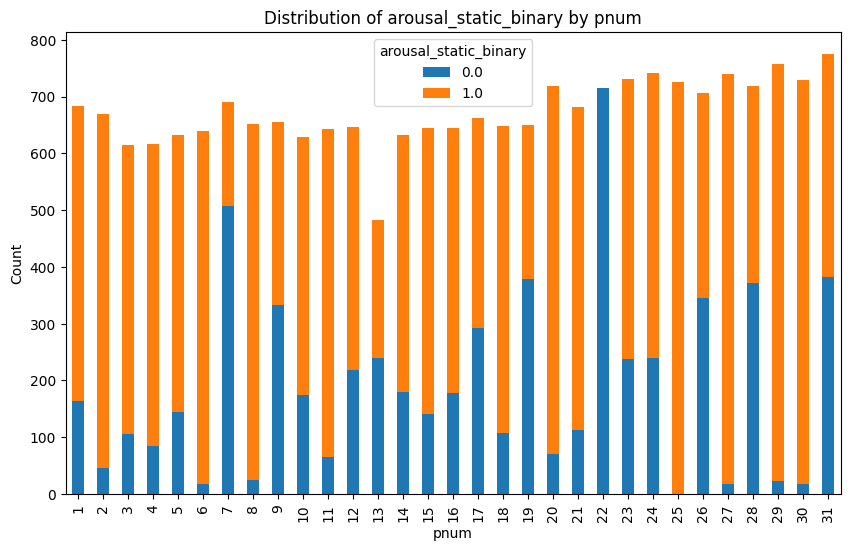

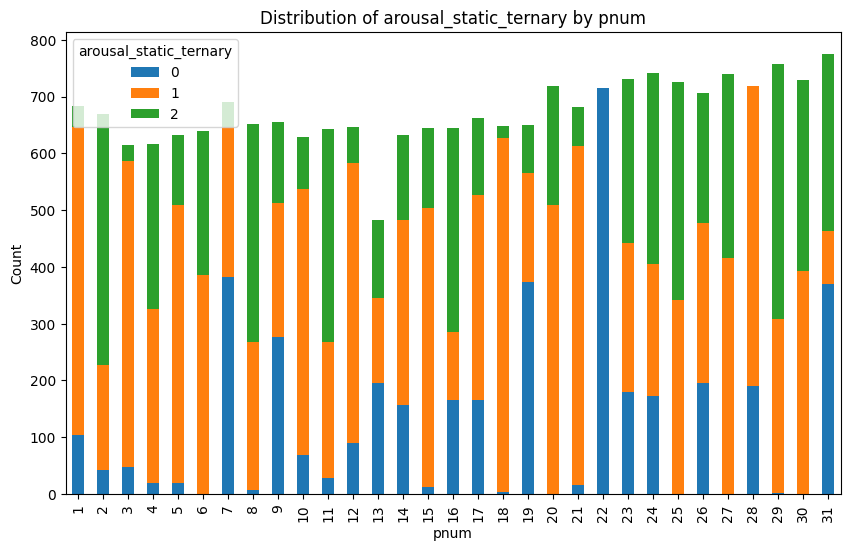

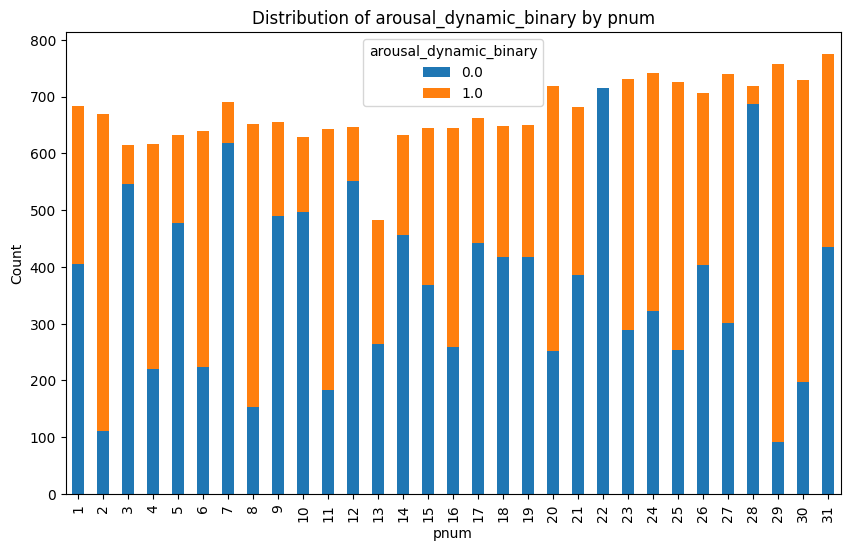

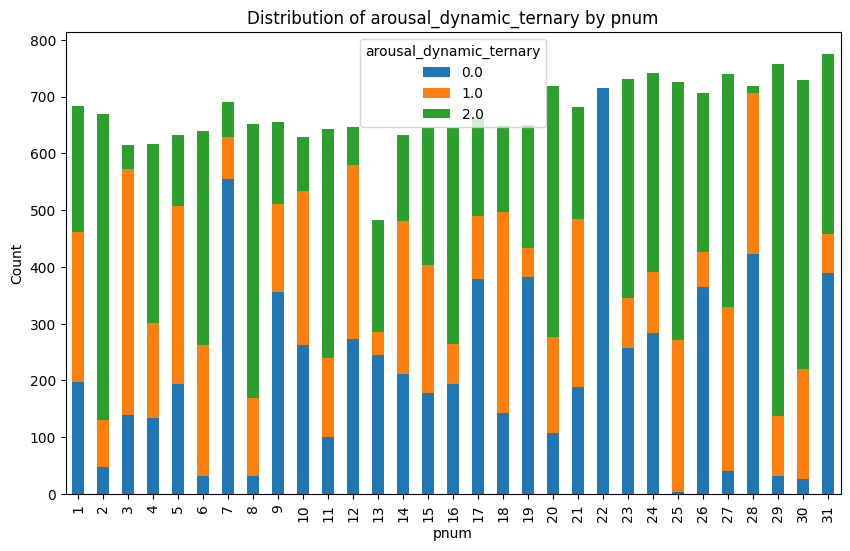

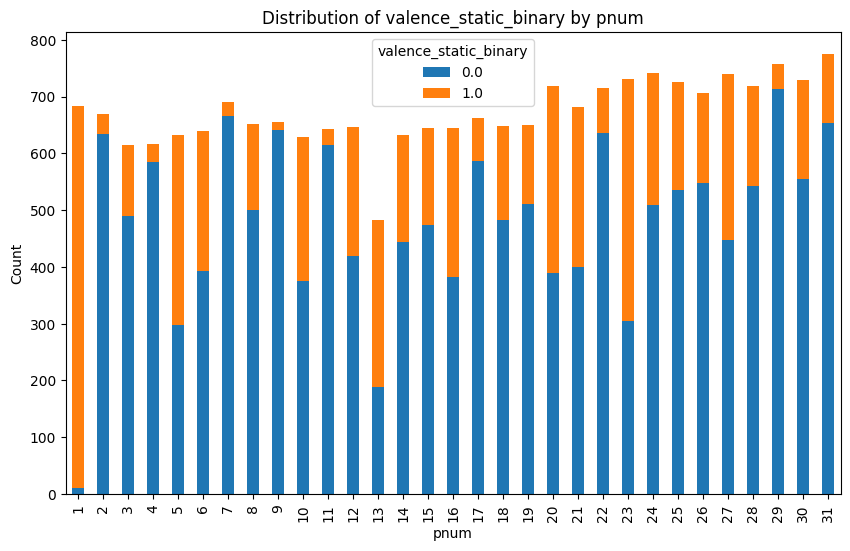

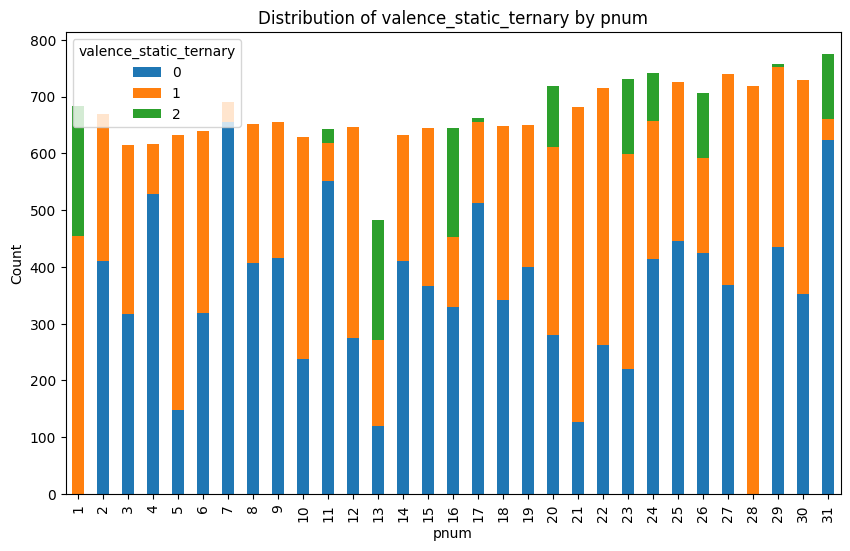

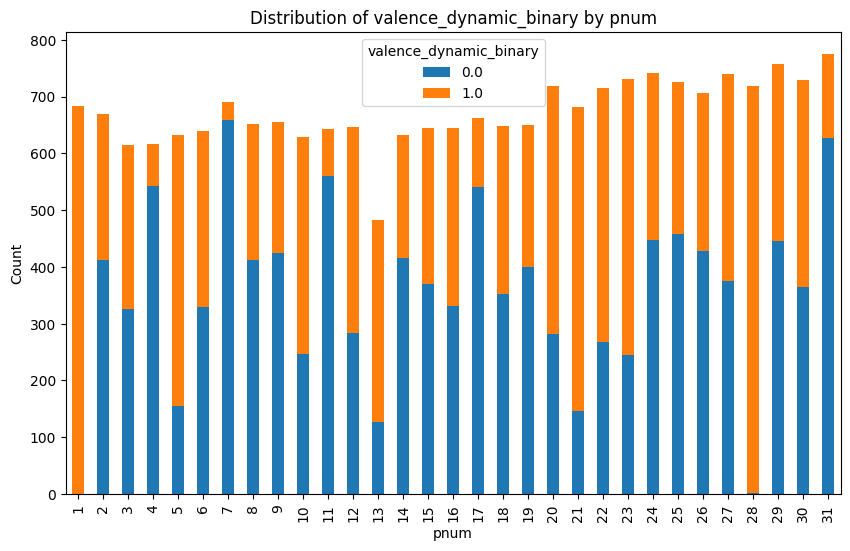

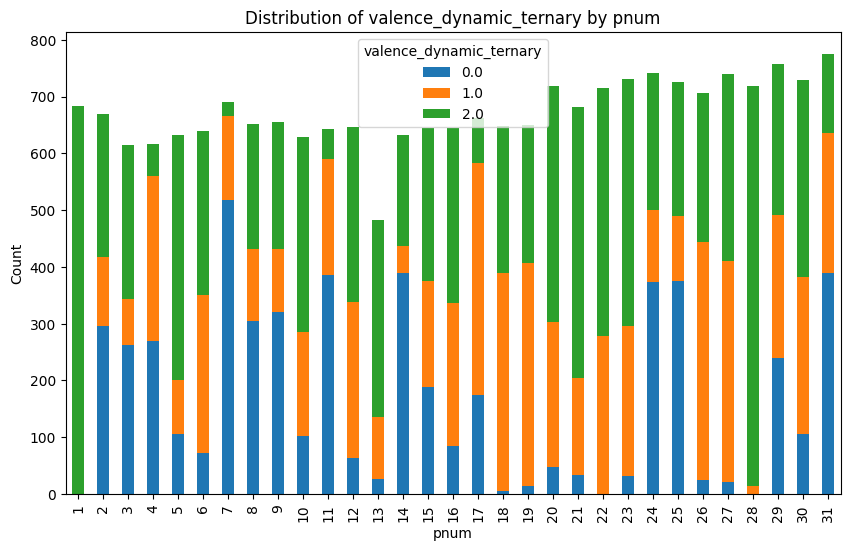

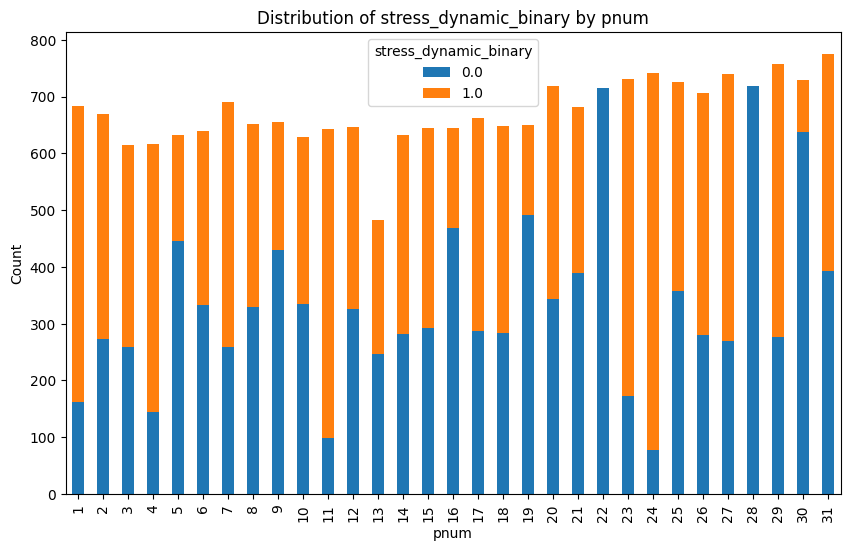

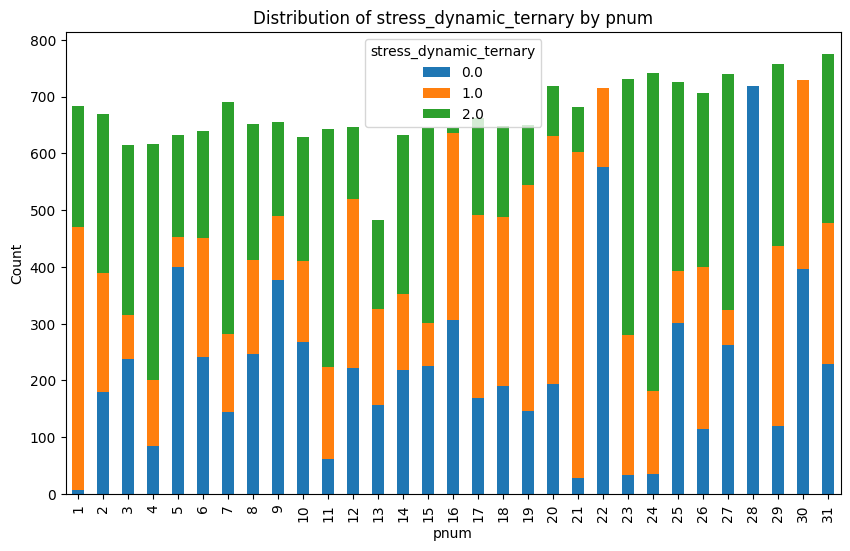

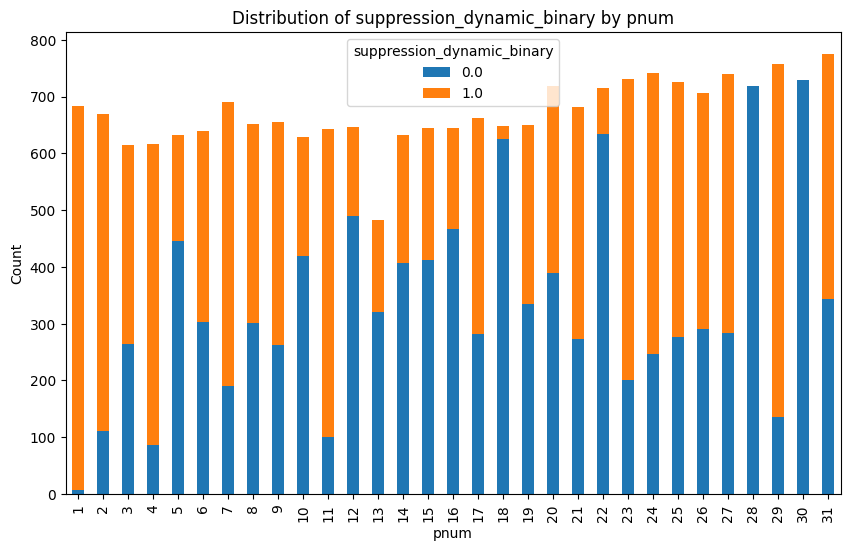

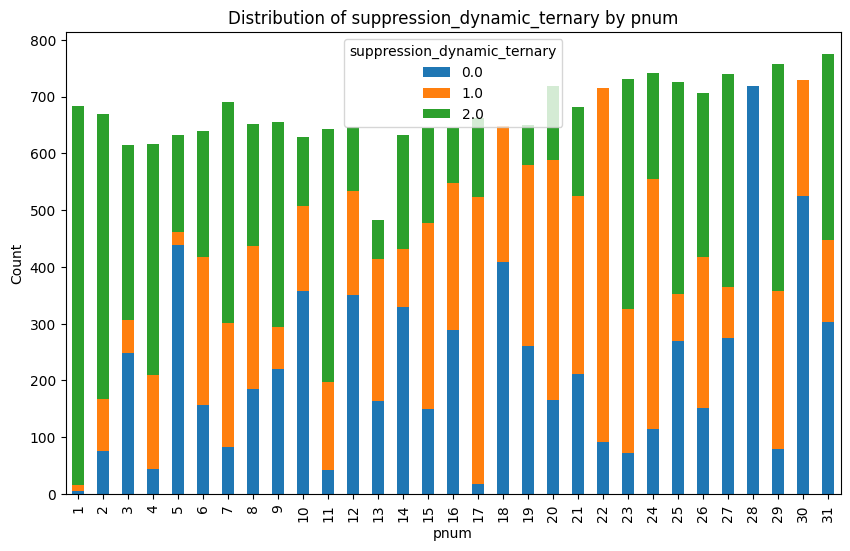

In [52]:
def plot_all_stacked_bar_label_distributions(df):
    # 라벨 컬럼: 'pnum', 'session'을 제외한 모든 컬럼
    label_columns = [col for col in df.columns if col not in ['pnum', 'session']]
    
    for label in label_columns:
        distribution = df.groupby(['pnum', label]).size().unstack(fill_value=0)
        distribution.plot(kind='bar', stacked=True, figsize=(10, 6))
        plt.title(f"Distribution of {label} by pnum")
        plt.xlabel("pnum")
        plt.ylabel("Count")
        plt.legend(title=label)
        plt.show()

# 사용 예제: encoded_df는 앞서 생성된 라벨 데이터셋
plot_all_stacked_bar_label_distributions(encoded_LABEL)

### Data integeration 

In [8]:
temp_AUDIO_CUSTOMER = AUDIO_CUSTOMER.drop(columns='Timestamp').reset_index(drop=True)
temp_AUDIO_WORKER = AUDIO_WORKER.drop(columns='Timestamp').reset_index(drop=True)

temp_EDA_MEAN = EDA_MEAN[EDA_MEAN.columns.drop('Timestamp')].reset_index(drop=True)
temp_EDA_PEAK = EDA_PEAK[EDA_PEAK.columns.drop('Timestamp')].reset_index(drop=True)
temp_EEG_MEAN_BANDPOWER = EEG_MEAN_BANDPOWER[EEG_MEAN_BANDPOWER.columns.drop('Timestamp')].reset_index(drop=True)
temp_TEMP_MEAN = TEMP_MEAN[TEMP_MEAN.columns.drop('Timestamp')].reset_index(drop=True)
temp_ACC_MEAN = ACC_MEAN[ACC_MEAN.columns.drop('Timestamp')].reset_index(drop=True)
temp_ECG_HRV = ECG_HRV[ECG_HRV.columns.drop(['Timestamp', 'Datetime'])].reset_index(drop=True)
temp_ECG_HR = ECG_HR[ECG_HR.columns.drop(['Timestamp', 'Datetime'])].reset_index(drop=True)

temp_LABEL = encoded_LABEL[encoded_LABEL.columns].reset_index(drop=True)

result = pd.concat([temp_AUDIO_CUSTOMER, temp_AUDIO_WORKER, temp_EDA_MEAN, temp_EDA_PEAK, temp_EEG_MEAN_BANDPOWER, temp_TEMP_MEAN, temp_ACC_MEAN, temp_ECG_HRV, temp_ECG_HR, temp_LABEL], axis=1)


In [9]:
result_nona = result.dropna().reset_index(drop=True)
print(result.shape) # (20875, 242)
print(result_nona.shape) # (20875, 242)


(20875, 242)
(20875, 242)


In [10]:
def select_only_gt_label_keep_non_labels(df, gt_label):
    label_columns = [col for col in df.columns if ('_binary' in col or '_ternary' in col)]
    
    if gt_label not in label_columns:
        raise ValueError(f"'{gt_label}' 컬럼은 라벨 컬럼으로 인식되지 않습니다. 감지된 라벨 컬럼: {label_columns}")
    
    # 라벨이 아닌 컬럼은 모두 선택
    non_label_columns = [col for col in df.columns if col not in label_columns]
    
    # 최종적으로 유지할 컬럼: 라벨이 아닌 모든 컬럼 + 선택한 gt_label
    columns_to_keep = non_label_columns + [gt_label]
    t_df = df[columns_to_keep].copy()
    t_df.rename(columns={gt_label: "label"}, inplace=True)

    return t_df

## Model_LOSO

In [11]:
MODEL_DICT = {
    "DecisionTree": DecisionTreeClassifier(criterion='entropy', min_samples_split=20), # Referred to WESAD
    "SVM": SVC(probability=True, kernel='rbf', C=107, gamma=0.001), # Referred to Mishra's paper (https://dl.acm.org/doi/pdf/10.1145/3432220)
    "RandomForest":RandomForestClassifier(criterion='gini', min_samples_split=20, n_estimators=100), # Referred to WESAD
    "XGBoost": None,
    "kNN": KNeighborsClassifier(n_neighbors=9) # Referred to WESAD
}

In [12]:
def run_experiments(df, n_runs=1, output_dir="Results"):
    os.makedirs(output_dir, exist_ok=True)
    # 여러 라벨, 타입, 레벨 조합
    label_list = ["stress", "arousal", "valence", "suppression"]
    type_list = ["static", "dynamic"]
    level_list = ["binary", "ternary"]

    for label in label_list:
        for type_ in type_list:
            # 만약 stress, suppression에서는 static이 없으니 스킵
            if label in ["stress", "suppression"] and type_ == "static":
                print(f"Skipping {label} / {type_} because it's not available.")
                continue
        
            for level in level_list:
                GT = f"{label}_{type_}_{level}"  # 예: "stress_dynamic_binary"
                final_df = select_only_gt_label_keep_non_labels(df, GT)
                #print(final_df.head())
                print("\n=== Running for GT:", GT, "===")
                results_all_models = {}

                for model_name, model_obj in MODEL_DICT.items():
                    if model_name == "XGBoost":
                        if level == 'binary':
                            # 이진 분류용
                            model_obj = xgb.XGBClassifier(
                                objective='binary:logistic',
                                max_depth=3,
                                learning_rate=0.1,
                                n_estimators=100,
                                use_label_encoder=False,
                                eval_metric='mlogloss'
                            )
                        else:
                            # 다중(삼진) 분류용
                            model_obj = xgb.XGBClassifier(
                                objective='multi:softprob',
                                num_class=3,
                                max_depth=3,
                                learning_rate=0.1,
                                n_estimators=100,
                                use_label_encoder=False,
                                eval_metric='mlogloss')

                    model_out_dir = os.path.join(output_dir, model_name, GT)
                    os.makedirs(model_out_dir, exist_ok=True)
                    all_runs_records = []  # 모든 run×test 결과를 쌓아둘 리스트

                    for run_i in range(n_runs):

                        X_features = final_df.drop(['pnum', 'session','label'], axis=1, errors='ignore')
                        y_label = final_df['label']

                        # Group = pnum
                        PIDS = final_df['pnum']
                        splitter = LeaveOneGroupOut()

                        run_records = []

                        for I_train, I_test in splitter.split(X_features, y_label, PIDS):
                            X_train, X_test = X_features.iloc[I_train], X_features.iloc[I_test]
                            y_train, y_test = y_label.iloc[I_train], y_label.iloc[I_test]
                            test_name = np.unique(PIDS[I_test])[0]

                            if len(np.unique(y_test)) == 1:
                                print(f"Warning: Test set for p{test_name} has only one unique label. Skipping.")
                                continue

                            # 모델 복제해서 fit
                            # 일부 모델(XGB 등)은 fit 후 internal state가 변하므로, 매번 새로 생성(또는 deepcopy)
                            # 여기서는 단순 model_obj.__class__(...) 로 새 인스턴스 만듦
                            clf_params = model_obj.get_params()
                            clf_type = model_obj.__class__
                            clf = clf_type(**clf_params)

                            # fit
                            clf.fit(X_train, y_train)

                            # predict
                            y_pred = clf.predict(X_test)

                            try:
                                y_prob = clf.predict_proba(X_test)
                            except:
                                y_prob = None
                                print(model_name, "does not support predict_proba()")

                            # 성능 지표 계산
                            if level == 'ternary':
                                # 3개 클래스 이상
                                # 다중 클래스 f1/precision/recall -> average='macro' 등 지정
                                acc = accuracy_score(y_test, y_pred)
                                f1_macro = f1_score(y_test, y_pred, average='macro')
                                precision_macro = precision_score(y_test, y_pred, average='macro')
                                recall_macro = recall_score(y_test, y_pred, average='macro')

                                # AUC (multi-class)
                                if y_prob is not None:
                                    # shape = (n_samples, n_classes)
                                    unique_labels = np.unique(y_test)
                                    if len(unique_labels) == y_prob.shape[1]:
                                        # 다중클래스 auc
                                        # roc_auc_score: multi_class='ovr' or 'ovo'
                                        auc_ovr = roc_auc_score(y_test, y_prob, multi_class='ovr')
                                        auc_ovo = roc_auc_score(y_test, y_prob, multi_class='ovo')
                                    else:
                                        auc_ovr, auc_ovo = np.nan, np.nan
                                else:
                                    auc_ovr, auc_ovo = np.nan, np.nan

                                cm = confusion_matrix(y_test, y_pred)
                                result_dict = {
                                    'test_name': f"p{test_name}",
                                    'accuracy': acc,
                                    'f1_macro': f1_macro,
                                    'precision_macro': precision_macro,
                                    'recall_macro': recall_macro,
                                    'auc_ovr': auc_ovr,
                                    'auc_ovo': auc_ovo,
                                    'confusion_matrix': cm
                                }

                            else:
                                # binary
                                acc = accuracy_score(y_test, y_pred)
                                f1 = f1_score(y_test, y_pred, average='binary')
                                precision_ = precision_score(y_test, y_pred, average='binary')
                                recall_ = recall_score(y_test, y_pred, average='binary')

                                # AUC
                                if y_prob is not None and y_prob.shape[1] == 2:
                                    # positive class의 확률
                                    y_prob_pos = y_prob[:, 1]
                                    auc_ = roc_auc_score(y_test, y_prob_pos)
                                else:
                                    auc_ = np.nan

                                cm = confusion_matrix(y_test, y_pred)
                                result_dict = {
                                    'test_name': f"p{test_name}",
                                    'accuracy': acc,
                                    'f1_score': f1,
                                    'precision': precision_,
                                    'recall': recall_,
                                    'auc': auc_,
                                    'confusion_matrix': cm
                                }

                            run_records.append(result_dict)

                        # 이번 run의 모든 test 결과 DataFrame
                        run_records_df = pd.DataFrame(run_records)
                        run_records_df['run_i'] = run_i
                        all_runs_records.append(run_records_df)

                    # (모델별) 모든 run×test 결과 합치기
                    if len(all_runs_records) == 0:
                        print(f"No valid results for model={model_name} / GT={GT}. Skipping.")
                        continue
                    all_df = pd.concat(all_runs_records, ignore_index=True)

                    # 파일로 저장(각 모델 / GT 별로)
                    save_csv_path = os.path.join(model_out_dir, f"all_runs_results.csv")
                    all_df.to_csv(save_csv_path, index=False, encoding='utf-8-sig')
                    print(f"Saved detailed test results -> {save_csv_path}")

                    # 요약(평균±표준편차) 계산
                    if level == 'ternary':
                        # 다중 클래스 -> columns: accuracy, f1_macro, precision_macro, recall_macro, auc_ovr, auc_ovo
                        summary_cols = ['accuracy', 'f1_macro', 'precision_macro', 'recall_macro', 'auc_ovr', 'auc_ovo']
                    else:
                        summary_cols = ['accuracy', 'f1_score', 'precision', 'recall', 'auc']

                    mean_vals = all_df[summary_cols].mean()
                    std_vals = all_df[summary_cols].std()

                    # 요약 저장
                    summary_df = pd.DataFrame({
                        'metric': summary_cols,
                        'mean': mean_vals.values,
                        'std': std_vals.values
                    })
                    summary_csv_path = os.path.join(model_out_dir, f"summary_{n_runs}runs.csv")
                    summary_df.to_csv(summary_csv_path, index=False, encoding='utf-8-sig')
                    print(f"Saved summary -> {summary_csv_path}")

                    # 필요하다면, 출력
                    print(f"\n[{model_name}][{GT}] Mean±Std:")
                    print(summary_df)

    print("\n=== All experiments done! ===")


In [ ]:
run_experiments(result_nona, n_runs=1, output_dir="Results")

Skipping stress / static because it's not available.

=== Running for GT: stress_dynamic_binary ===
Saved detailed test results -> Results/DecisionTree/stress_dynamic_binary/all_runs_results.csv
Saved summary -> Results/DecisionTree/stress_dynamic_binary/summary_1runs.csv

[DecisionTree][stress_dynamic_binary] Mean±Std:
      metric      mean       std
0   accuracy  0.558839  0.122638
1   f1_score  0.559349  0.144381
2  precision  0.596405  0.179975
3     recall  0.569644  0.192438
4        auc  0.571174  0.145389


# Code (for Hide and seek )

### Decision Tree

In [ ]:
three_performance_mean = pd.DataFrame(columns=['accuracy', 'f1_macro', 'f1_micro', 'auc_ovr'])
three_performance_std = pd.DataFrame(columns=['accuracy', 'f1_macro', 'f1_micro', 'auc_ovr'])
binary_performance_mean = pd.DataFrame(columns=['accuracy', 'f1_score', 'auc'])
binary_performance_std = pd.DataFrame(columns=['accuracy', 'f1_score', 'auc'])

for i in range(1):
    X_features=pd.DataFrame()
    if level == 'ternary':
        X_features = final_df.drop(['pnum', 'session','label'], axis=1)
        y_label = final_df['label']
    else:
        X_features = final_df.drop(['pnum', 'session','label'], axis=1)
        y_label = final_df['label']

    PIDS = final_df['pnum']

    test = []
    pred = []
    importance = [] 

    RESULTS_AVAL_DT, MODELS_AVAL_DT, TRAIN_SETS_AVAL_DT = [], {}, {}
    splitter = LeaveOneGroupOut()

    for I_train, I_test in splitter.split(X_features, y_label, PIDS):
        X_train, X_test = X_features.iloc[I_train], X_features.iloc[I_test] 
        y_train, y_test = y_label.iloc[I_train], y_label.iloc[I_test]
        test_name = np.unique(PIDS[I_test])[0]
        print(test_name)    

        # 테스트 데이터의 레이블이 하나만 존재하는 경우 경고 메시지 출력 후 건너뛰기
        if len(np.unique(y_test)) == 1:
            print(f"Warning: Test set for {test_name} has only one unique label. Skipping this split.")
            continue

        # Basic
        clf = DecisionTreeClassifier(criterion='entropy', min_samples_split=20) # Referred to WESAD
        clf.fit(X_train, y_train)

        y_pred = clf.predict(X_test)
        y_prob = clf.predict_proba(X_test)[:,1]

        #if call_three_label:
        if level == 'ternary': 
            y_score = clf.predict_proba(X_test) 
            unique_labels = np.unique(y_test)
            if len(unique_labels) != y_score.shape[1]:
                print(f"Error: The number of unique labels in y_test ({len(unique_labels)}) does not match the number of columns in y_score ({y_score.shape[1]}).")
            else:
                # 여기에 roc_auc_score 계산 코드 추가
                auc_ovo = roc_auc_score(y_test, y_score, multi_class='ovo')
                auc_ovr = roc_auc_score(y_test, y_score, multi_class='ovr')
                RESULTS_AVAL_DT.append({
                'accuracy':accuracy_score(y_test, y_pred),
                'confusion_matrix': confusion_matrix(y_test, y_pred),
                'f1_macro': f1_score(y_test, y_pred, average='macro'),
                'f1_micro': f1_score(y_test, y_pred, average='micro'),
                'f1_weighted': f1_score(y_test, y_pred, average='weighted'),
                'auc_ovo': roc_auc_score(y_test, y_score, multi_class='ovo'),
                'auc_ovr': roc_auc_score(y_test, y_score, multi_class='ovr'),
                'test_name': 'p'+str(test_name)
                })
        else:
            RESULTS_AVAL_DT.append({
            'accuracy':accuracy_score(y_test, y_pred),
            'confusion_matrix': confusion_matrix(y_test, y_pred),
            'f1_score': f1_score(y_test, y_pred),
            'auc': roc_auc_score(y_test, y_prob),
            'test_name': 'p'+str(test_name)
            })


        MODELS_AVAL_DT[test_name] = clf
        TRAIN_SETS_AVAL_DT[test_name] = X_train

        test.append(y_pred)
        pred.append(y_test)
        importance.append(clf.feature_importances_)


    # Result value append
    RESULTS_AVAL_DT = pd.DataFrame(RESULTS_AVAL_DT)

    if level == 'ternary':
    #if call_three_label: 
        print(RESULTS_AVAL_DT[['accuracy','f1_macro', 'f1_micro', 'f1_weighted', 'auc_ovo', 'auc_ovr']].mean())
        print(RESULTS_AVAL_DT[['accuracy','f1_macro', 'f1_micro', 'f1_weighted', 'auc_ovo', 'auc_ovr']].std())
        three_performance_mean.loc[len(three_performance_mean)] = RESULTS_AVAL_DT[['accuracy','f1_macro', 'f1_micro', 'auc_ovr']].mean()
        three_performance_std.loc[len(three_performance_std)] = RESULTS_AVAL_DT[['accuracy','f1_macro', 'f1_micro', 'auc_ovr']].std()
    else:
        print(RESULTS_AVAL_DT[['accuracy','f1_score', 'auc']].mean())
        print(RESULTS_AVAL_DT[['accuracy','f1_score', 'auc']].std())
        binary_performance_mean.loc[len(binary_performance_mean)] = RESULTS_AVAL_DT[['accuracy','f1_score', 'auc']].mean()
        binary_performance_std.loc[len(binary_performance_std)] = RESULTS_AVAL_DT[['accuracy','f1_score', 'auc']].std()



1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
Error: The number of unique labels in y_test (2) does not match the number of columns in y_score (3).
23
24
25
26
27
28
Error: The number of unique labels in y_test (2) does not match the number of columns in y_score (3).
29
30
31
accuracy       0.353940
f1_macro       0.304403
f1_micro       0.353940
f1_weighted    0.366237
auc_ovo        0.533726
auc_ovr        0.533078
dtype: float64
accuracy       0.110724
f1_macro       0.096756
f1_micro       0.110724
f1_weighted    0.125318
auc_ovo        0.071350
auc_ovr        0.071379
dtype: float64


## Random Forest

In [ ]:
three_performance_mean = pd.DataFrame(columns=['accuracy', 'f1_macro', 'f1_micro', 'auc_ovr'])
three_performance_std = pd.DataFrame(columns=['accuracy', 'f1_macro', 'f1_micro', 'auc_ovr'])

binary_performance_mean = pd.DataFrame(columns=['accuracy', 'f1_score', 'auc'])
binary_performance_std = pd.DataFrame(columns=['accuracy', 'f1_score', 'auc'])



for i in range(1): 

    two_layer = False

    X_features=pd.DataFrame()

    if call_label:
        X_features = final_df.drop(['pnum', 'call_label'], axis=1)
        y_label = final_df['call_label']
    else:
        X_features = final_df.drop(['pnum', 'session','label'], axis=1)
        y_label = final_df['label']
        print('test')

    PIDS = final_df['pnum']

    test = []
    pred = []
    importance = [] 

    RESULTS_AVAL_RF, MODELS_AVAL_RF, TRAIN_SETS_AVAL_RF = [], {}, {}
    splitter = LeaveOneGroupOut()

    # for SHAP
    all_SHAP_values =[]
    all_data = []

    for I_train, I_test in splitter.split(X_features, y_label, PIDS):
        X_train, X_test = X_features.iloc[I_train], X_features.iloc[I_test] 
        y_train, y_test = y_label.iloc[I_train], y_label.iloc[I_test]
        test_name = np.unique(PIDS[I_test])[0]
        print(test_name)    

        # 테스트 데이터의 레이블이 하나만 존재하는 경우 경고 메시지 출력 후 건너뛰기
        if len(np.unique(y_test)) == 1:
            print(f"Warning: Test set for {test_name} has only one unique label. Skipping this split.")
            continue


        # Basic
        clf = RandomForestClassifier(criterion='gini', min_samples_split=20, n_estimators=100) # Referred to WESAD
        clf.fit(X_train, y_train)

        # '''SHAP, 매 모델마다 나옴 binary classify 각각의 결과에 의한 영향을 플롯으로 출력 '''
        # explainer = shap.Explainer(clf)
        # shap_values = explainer(X_test)
        # all_SHAP_values.append(shap_values.values)
        # all_data.append(shap_values.data)

        # all_SHAP_values_array = np.concatenate(all_SHAP_values, axis=0) ## for sharply value 
        # all_data_array = np.concatenate(all_data, axis=0) ## for feature high low         
        # #print(all_SHAP_values_array[:,:,1].shape) #debugging
        # #print(np.unique(all_SHAP_values_array[:,:,1])) #debugging  

        # plt.rcParams.update({'font.size': 12}) #change the font.size 
        # #shap.summary_plot(all_SHAP_values_array[:,:,1], all_data_array, feature_names=X_features.columns, plot_type='dot', max_display=10)

        y_pred = clf.predict(X_test)
        y_prob = clf.predict_proba(X_test)[:,1]

        # # Two Layer 
        # two_layer = False    
        # if two_layer: 
        #     CLF_THRESHOLD = 0.7
        #     ALPHA = 0.54
        #     GAMMA = 0.33
        #     DELTA = 0.86
            
        #     D, yi_1 = [], None
        #     X_test = X_test.reset_index(drop=True)
        #     for idx in X_test.index:
        #         xi = clf.predict(pd.DataFrame(X_test.iloc[idx, (X_test.columns != 'pnum') & (X_test.columns != 'cond') & (X_test.columns != 'stress_gt')]).T)[0]

        #         if not D or D[-1] == xi:
        #             yi = xi
        #         else:
        #             # yi = Pipeline.Params.ALPHA * xi + (1 - Pipeline.Params.ALPHA) * D[-1]  # noqa, exponential smoothing
        #             yi = GAMMA*(1 - yi_1)*xi + DELTA*yi_1*(1 - xi) + yi_1*xi   # two-layer

        #         Di = 1 if yi >= CLF_THRESHOLD else 0
        #         D.append(Di)
        #         yi_1 = yi

        #     res = filter(lambda x: x[0] != -1, zip(y_test.values, D))
        #     y_test, y_pred = zip(*res)

        if tertile:
        #if call_three_label:
            y_score = clf.predict_proba(X_test) 
            RESULTS_AVAL_RF.append({
            'accuracy':accuracy_score(y_test, y_pred),
            'confusion_matrix': confusion_matrix(y_test, y_pred),
            'f1_macro': f1_score(y_test, y_pred, average='macro'),
            'f1_micro': f1_score(y_test, y_pred, average='micro'),
            'f1_weighted': f1_score(y_test, y_pred, average='weighted'),
            'auc_ovo': roc_auc_score(y_test, y_score, multi_class='ovo'),
            'auc_ovr': roc_auc_score(y_test, y_score, multi_class='ovr'),
            'test_name': 'p'+str(test_name)
            })
        else:
            RESULTS_AVAL_RF.append({
            'accuracy':accuracy_score(y_test, y_pred),
            'confusion_matrix': confusion_matrix(y_test, y_pred),
            'f1_score': f1_score(y_test, y_pred),
            'auc': roc_auc_score(y_test, y_prob),
            'test_name': 'p'+str(test_name)
            })

        print('test:', test_name, accuracy_score(y_test, y_pred), confusion_matrix(y_test, y_pred), f1_score(y_test, y_pred), roc_auc_score(y_test, y_prob) )


        MODELS_AVAL_RF[test_name] = clf
        TRAIN_SETS_AVAL_RF[test_name] = X_train

        test.append(y_pred)
        pred.append(y_test)
        importance.append(clf.feature_importances_)


    #SHAP value graph
    # shap.summary_plot(all_SHAP_values_array[:,:,1],feature_names=X_features.columns, plot_type='dot', max_display=10)


    
    RESULTS_AVAL_RF = pd.DataFrame(RESULTS_AVAL_RF)
    RESULTS_AVAL_RF.to_csv(f'Results/RF_test{i+1}.csv')

    if tertile:
    #if call_three_label: 
        print(RESULTS_AVAL_RF[['accuracy','f1_macro', 'f1_micro', 'f1_weighted', 'auc_ovo', 'auc_ovr']].mean())
        print(RESULTS_AVAL_RF[['accuracy','f1_macro', 'f1_micro', 'f1_weighted', 'auc_ovo', 'auc_ovr']].std())
        three_performance_mean.loc[len(three_performance_mean)] = RESULTS_AVAL_RF[['accuracy','f1_macro', 'f1_micro', 'auc_ovr']].mean()
        three_performance_std.loc[len(three_performance_std)] = RESULTS_AVAL_RF[['accuracy','f1_macro', 'f1_micro', 'auc_ovr']].std()   
    else:
        print(RESULTS_AVAL_RF[['accuracy','f1_score', 'auc']].mean())
        print(RESULTS_AVAL_RF[['accuracy','f1_score', 'auc']].std())
        binary_performance_mean.loc[len(binary_performance_mean)] = RESULTS_AVAL_RF[['accuracy', 'f1_score', 'auc']].mean()
        binary_performance_std.loc[len(binary_performance_std)] = RESULTS_AVAL_RF[['accuracy','f1_score', 'auc']].std()


test
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
accuracy    0.718146
f1_score    0.817330
auc         0.496507
dtype: float64
accuracy    0.205346
f1_score    0.156364
auc         0.164409
dtype: float64


In [163]:
RESULTS_AVAL_RF = pd.DataFrame(RESULTS_AVAL_RF)

if tertile:
#if call_three_label: 
    print(RESULTS_AVAL_RF[['accuracy','f1_macro', 'f1_micro', 'f1_weighted', 'auc_ovo', 'auc_ovr']].mean())
    print(RESULTS_AVAL_RF[['accuracy','f1_macro', 'f1_micro', 'f1_weighted', 'auc_ovo', 'auc_ovr']].std())   
else:
    print(RESULTS_AVAL_RF[['accuracy','f1_score', 'auc']].mean())
    print(RESULTS_AVAL_RF[['accuracy','f1_score', 'auc']].std())

accuracy    0.615530
f1_score    0.598411
auc         0.738597
dtype: float64
accuracy    0.132769
f1_score    0.171497
auc         0.121425
dtype: float64


## kNN

In [ ]:
three_performance_mean = pd.DataFrame(columns=['accuracy', 'f1_macro', 'f1_micro', 'auc_ovr'])
three_performance_std = pd.DataFrame(columns=['accuracy', 'f1_macro', 'f1_micro', 'auc_ovr'])

binary_performance_mean = pd.DataFrame(columns=['accuracy', 'f1_score', 'auc'])
binary_performance_std = pd.DataFrame(columns=['accuracy', 'f1_score', 'auc'])

for i in range(5): 
    two_layer = False

    X_features=pd.DataFrame()

    if call_label:
        X_features = result_nona.drop(['pnum', 'call_label'], axis=1)
        y_label = result_nona['call_label']
    elif call_three_label: 
        X_features = result_nona.drop(['pnum', 'call_three_label'], axis=1)
        y_label = result_nona['call_three_label']
    else:
        X_features = result_nona.drop(['suppress', 'pnum', 'ternarized'], axis=1)
        y_label = result_nona['ternarized']

    PIDS = result_nona['pnum']

    test = []
    pred = []
    importance = [] 

    RESULTS_AVAL_kNN, MODELS_AVAL_kNN, TRAIN_SETS_AVAL_kNN = [], {}, {}
    splitter = LeaveOneGroupOut()

    for I_train, I_test in splitter.split(X_features, y_label, PIDS):
        X_train, X_test = X_features.iloc[I_train], X_features.iloc[I_test] 
        y_train, y_test = y_label.iloc[I_train], y_label.iloc[I_test]
        test_name = np.unique(PIDS[I_test])[0]
        print(test_name)    

        # Basic
        clf = KNeighborsClassifier(n_neighbors=9) # Referred to WESAD
        clf.fit(X_train, y_train)

        y_pred = clf.predict(X_test)
        y_prob = clf.predict_proba(X_test)[:,1]

        # Two Layer 
        two_layer = False    
        if two_layer: 
            CLF_THRESHOLD = 0.7
            ALPHA = 0.54
            GAMMA = 0.33
            DELTA = 0.86
            
            D, yi_1 = [], None
            X_test = X_test.reset_index(drop=True)
            for idx in X_test.index:
                xi = clf.predict(pd.DataFrame(X_test.iloc[idx, (X_test.columns != 'pnum') & (X_test.columns != 'cond') & (X_test.columns != 'stress_gt')]).T)[0]

                if not D or D[-1] == xi:
                    yi = xi
                else:
                    # yi = Pipeline.Params.ALPHA * xi + (1 - Pipeline.Params.ALPHA) * D[-1]  # noqa, exponential smoothing
                    yi = GAMMA*(1 - yi_1)*xi + DELTA*yi_1*(1 - xi) + yi_1*xi   # two-layer

                Di = 1 if yi >= CLF_THRESHOLD else 0
                D.append(Di)
                yi_1 = yi

            res = filter(lambda x: x[0] != -1, zip(y_test.values, D))
            y_test, y_pred = zip(*res)

        if tertile:
        #if call_three_label:
            y_score = clf.predict_proba(X_test) 
            RESULTS_AVAL_kNN.append({
            'accuracy':accuracy_score(y_test, y_pred),
            'confusion_matrix': confusion_matrix(y_test, y_pred),
            'f1_macro': f1_score(y_test, y_pred, average='macro'),
            'f1_micro': f1_score(y_test, y_pred, average='micro'),
            'f1_weighted': f1_score(y_test, y_pred, average='weighted'),
            'auc_ovo': roc_auc_score(y_test, y_score, multi_class='ovo'),
            'auc_ovr': roc_auc_score(y_test, y_score, multi_class='ovr'),
            'test_name': 'p'+str(test_name)
            })
        else:
            RESULTS_AVAL_kNN.append({
            'accuracy':accuracy_score(y_test, y_pred),
            'confusion_matrix': confusion_matrix(y_test, y_pred),
            'f1_score': f1_score(y_test, y_pred),
            'auc': roc_auc_score(y_test, y_prob),
            'test_name': 'p'+str(test_name)
            })


        MODELS_AVAL_kNN[test_name] = clf
        TRAIN_SETS_AVAL_kNN[test_name] = X_train

        test.append(y_pred)
        pred.append(y_test)

    RESULTS_AVAL_kNN = pd.DataFrame(RESULTS_AVAL_kNN)

    if tertile:
    #if call_three_label: 
        print(RESULTS_AVAL_kNN[['accuracy','f1_macro', 'f1_micro', 'f1_weighted', 'auc_ovo', 'auc_ovr']].mean())
        print(RESULTS_AVAL_kNN[['accuracy','f1_macro', 'f1_micro', 'f1_weighted', 'auc_ovo', 'auc_ovr']].std()) 
        three_performance_mean.loc[len(three_performance_mean)] = RESULTS_AVAL_kNN[['accuracy','f1_macro', 'f1_micro', 'auc_ovr']].mean()
        three_performance_std.loc[len(three_performance_std)] = RESULTS_AVAL_kNN[['accuracy','f1_macro', 'f1_micro', 'auc_ovr']].std()  
    else:
        print(RESULTS_AVAL_kNN[['accuracy','f1_score', 'auc']].mean())
        print(RESULTS_AVAL_kNN[['accuracy','f1_score', 'auc']].std())
        binary_performance_mean.loc[len(binary_performance_mean)] = RESULTS_AVAL_kNN[['accuracy', 'f1_score', 'auc']].mean()
        binary_performance_std.loc[len(binary_performance_std)] = RESULTS_AVAL_kNN[['accuracy','f1_score', 'auc']].std()   

In [ ]:
binary_performance_mean
print(time)

In [ ]:
binary_performance_std
print(time)

In [ ]:
RESULTS_AVAL_kNN = pd.DataFrame(RESULTS_AVAL_kNN)

if tertile:
#if call_three_label: 
    print(RESULTS_AVAL_kNN[['accuracy','f1_macro', 'f1_micro', 'f1_weighted', 'auc_ovo', 'auc_ovr']].mean())
    print(RESULTS_AVAL_kNN[['accuracy','f1_macro', 'f1_micro', 'f1_weighted', 'auc_ovo', 'auc_ovr']].std())   
else:
    print(RESULTS_AVAL_kNN[['accuracy','f1_score', 'auc']].mean())
    print(RESULTS_AVAL_kNN[['accuracy','f1_score', 'auc']].std())

## SVM

In [ ]:
three_performance_mean = pd.DataFrame(columns=['accuracy', 'f1_macro', 'f1_micro', 'auc_ovr'])
three_performance_std = pd.DataFrame(columns=['accuracy', 'f1_macro', 'f1_micro', 'auc_ovr'])

binary_performance_mean = pd.DataFrame(columns=['accuracy', 'f1_score', 'auc'])
binary_performance_std = pd.DataFrame(columns=['accuracy', 'f1_score', 'auc'])

for i in range(5):
    two_layer = False

    X_features=pd.DataFrame()

    if call_label:
        X_features = result_nona.drop(['pnum', 'call_label'], axis=1)
        y_label = result_nona['call_label']
    elif call_three_label: 
        X_features = result_nona.drop(['pnum', 'call_three_label'], axis=1)
        y_label = result_nona['call_three_label']
    else:
        X_features = result_nona.drop(['suppress', 'pnum', 'ternarized'], axis=1)
        y_label = result_nona['ternarized']

    PIDS = result_nona['pnum']

    test = []
    pred = []
    importance = [] 

    RESULTS_AVAL_SVM, MODELS_AVAL_SVM, TRAIN_SETS_AVAL_SVM = [], {}, {}
    splitter = LeaveOneGroupOut()

    for I_train, I_test in splitter.split(X_features, y_label, PIDS):
        X_train, X_test = X_features.iloc[I_train], X_features.iloc[I_test] 
        y_train, y_test = y_label.iloc[I_train], y_label.iloc[I_test]
        test_name = np.unique(PIDS[I_test])[0]
        print(test_name)    

        # Basic
        clf = SVC(probability=True, kernel='rbf', C=107, gamma=0.001) # Referred to Mishra's paper (https://dl.acm.org/doi/pdf/10.1145/3432220)
        clf.fit(X_train, y_train)


        y_pred = clf.predict(X_test)
        y_prob = clf.predict_proba(X_test)[:,1]

        # Two Layer 
        two_layer = False    
        if two_layer: 
            CLF_THRESHOLD = 0.7
            ALPHA = 0.54
            GAMMA = 0.33
            DELTA = 0.86
            
            D, yi_1 = [], None
            X_test = X_test.reset_index(drop=True)
            for idx in X_test.index:
                xi = clf.predict(pd.DataFrame(X_test.iloc[idx, (X_test.columns != 'pnum') & (X_test.columns != 'cond') & (X_test.columns != 'stress_gt')]).T)[0]

                if not D or D[-1] == xi:
                    yi = xi
                else:
                    # yi = Pipeline.Params.ALPHA * xi + (1 - Pipeline.Params.ALPHA) * D[-1]  # noqa, exponential smoothing
                    yi = GAMMA*(1 - yi_1)*xi + DELTA*yi_1*(1 - xi) + yi_1*xi   # two-layer

                Di = 1 if yi >= CLF_THRESHOLD else 0
                D.append(Di)
                yi_1 = yi

            res = filter(lambda x: x[0] != -1, zip(y_test.values, D))
            y_test, y_pred = zip(*res)

        if tertile:
        #if call_three_label:
            y_score = clf.predict_proba(X_test) 
            RESULTS_AVAL_SVM.append({
            'accuracy':accuracy_score(y_test, y_pred),
            'confusion_matrix': confusion_matrix(y_test, y_pred),
            'f1_macro': f1_score(y_test, y_pred, average='macro'),
            'f1_micro': f1_score(y_test, y_pred, average='micro'),
            'f1_weighted': f1_score(y_test, y_pred, average='weighted'),
            'auc_ovo': roc_auc_score(y_test, y_score, multi_class='ovo'),
            'auc_ovr': roc_auc_score(y_test, y_score, multi_class='ovr'),
            'test_name': 'p'+str(test_name)
            })
        else:
            RESULTS_AVAL_SVM.append({
            'accuracy':accuracy_score(y_test, y_pred),
            'confusion_matrix': confusion_matrix(y_test, y_pred),
            'f1_score': f1_score(y_test, y_pred),
            'auc': roc_auc_score(y_test, y_prob),
            'test_name': 'p'+str(test_name)
            })


        MODELS_AVAL_SVM[test_name] = clf
        TRAIN_SETS_AVAL_SVM[test_name] = X_train

        test.append(y_pred)
        pred.append(y_test)
    
    RESULTS_AVAL_SVM = pd.DataFrame(RESULTS_AVAL_SVM)
    if tertile:
    #if call_three_label: 
        print(RESULTS_AVAL_SVM[['accuracy','f1_macro', 'f1_micro', 'f1_weighted', 'auc_ovo', 'auc_ovr']].mean())
        print(RESULTS_AVAL_SVM[['accuracy','f1_macro', 'f1_micro', 'f1_weighted', 'auc_ovo', 'auc_ovr']].std())   
        three_performance_mean.loc[len(three_performance_mean)] = RESULTS_AVAL_SVM[['accuracy','f1_macro', 'f1_micro', 'auc_ovr']].mean()
        three_performance_std.loc[len(three_performance_std)] = RESULTS_AVAL_SVM[['accuracy','f1_macro', 'f1_micro', 'auc_ovr']].std()  
        
    else:
        print(RESULTS_AVAL_SVM[['accuracy','f1_score', 'auc']].mean())
        print(RESULTS_AVAL_SVM[['accuracy','f1_score', 'auc']].std())
        binary_performance_mean.loc[len(binary_performance_mean)] = RESULTS_AVAL_SVM[['accuracy', 'f1_score', 'auc']].mean()
        binary_performance_std.loc[len(binary_performance_std)] = RESULTS_AVAL_SVM[['accuracy','f1_score', 'auc']].std()  



In [ ]:
binary_performance_mean
print(time)

In [ ]:
binary_performance_std
print(time)

In [ ]:
RESULTS_AVAL_SVM = pd.DataFrame(RESULTS_AVAL_SVM)
if tertile:
#if call_three_label: 
    print(RESULTS_AVAL_SVM[['accuracy','f1_macro', 'f1_micro', 'f1_weighted', 'auc_ovo', 'auc_ovr']].mean())
    print(RESULTS_AVAL_SVM[['accuracy','f1_macro', 'f1_micro', 'f1_weighted', 'auc_ovo', 'auc_ovr']].std())   
else:
    print(RESULTS_AVAL_SVM[['accuracy','f1_score', 'auc']].mean())
    print(RESULTS_AVAL_SVM[['accuracy','f1_score', 'auc']].std())

## XGBoost

In [ ]:
three_performance_mean = pd.DataFrame(columns=['accuracy', 'f1_macro', 'f1_micro', 'auc_ovr'])
three_performance_std = pd.DataFrame(columns=['accuracy', 'f1_macro', 'f1_micro', 'auc_ovr'])

binary_performance_mean = pd.DataFrame(columns=['accuracy', 'f1_score', 'auc'])
binary_performance_std = pd.DataFrame(columns=['accuracy', 'f1_score', 'auc'])

#a = result(result_nona['pnum'].unique())
for i in range(5): 
    
    two_layer = False

    X_features=pd.DataFrame()

    if call_label:
        X_features = result_nona.drop(['pnum', 'call_label'], axis=1)
        y_label = result_nona['call_label']
    elif call_three_label: 
        X_features = result_nona.drop(['pnum', 'call_three_label'], axis=1)
        y_label = result_nona['call_three_label']
    else:
        X_features = result_nona.drop(['suppress', 'pnum', 'ternarized'], axis=1)
        y_label = result_nona['ternarized']

    PIDS = result_nona['pnum']

    test = []
    pred = []
    importance = []

    RESULTS_AVAL_XGB, MODELS_AVAL_XGB, TRAIN_SETS_AVAL_XGB = [], {}, {}
    splitter = LeaveOneGroupOut()

    for I_train, I_test in splitter.split(X_features, y_label, PIDS):
        X_train, X_test = X_features.iloc[I_train], X_features.iloc[I_test] 
        y_train, y_test = y_label.iloc[I_train], y_label.iloc[I_test]
        test_name = np.unique(PIDS[I_test])[0]
        print(test_name)    

        inner_splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
        I_train, I_eval = next(inner_splitter.split(X_train, y_train))
        X_train, X_eval = X_train.iloc[I_train], X_train.iloc[I_eval]
        y_train, y_eval = y_train.iloc[I_train], y_train.iloc[I_eval]

        # Basic
        clf = xgb.XGBClassifier(objective='binary:logistic', max_depth=3, learning_rate=0.1, n_estimators=100) # 은지언니가 찾은 논문 ref로 알고 있습니다
        if call_three_label: 
            clf = xgb.XGBClassifier(objective='multi:softmax', num_class=3, eval_metric='merror', max_depth=3, learning_rate=0.1, n_estimators=100) 

        clf.fit(X_train, y_train, eval_set=[(X_eval, y_eval)])

        y_pred = clf.predict(X_test)
        y_prob = clf.predict_proba(X_test)[:,1]

        # Two Layer 
        two_layer = False    
        if two_layer: 
            CLF_THRESHOLD = 0.7
            ALPHA = 0.54
            GAMMA = 0.33
            DELTA = 0.86
            
            D, yi_1 = [], None
            X_test = X_test.reset_index(drop=True)
            for idx in X_test.index:
                xi = clf.predict(pd.DataFrame(X_test.iloc[idx, (X_test.columns != 'pnum') & (X_test.columns != 'cond') & (X_test.columns != 'stress_gt')]).T)[0]

                if not D or D[-1] == xi:
                    yi = xi
                else:
                    # yi = Pipeline.Params.ALPHA * xi + (1 - Pipeline.Params.ALPHA) * D[-1]  # noqa, exponential smoothing
                    yi = GAMMA*(1 - yi_1)*xi + DELTA*yi_1*(1 - xi) + yi_1*xi   # two-layer

                Di = 1 if yi >= CLF_THRESHOLD else 0
                D.append(Di)
                yi_1 = yi

            res = filter(lambda x: x[0] != -1, zip(y_test.values, D))
            y_test, y_pred = zip(*res)


        #if call_three_label:
        if tertile:
            y_score = clf.predict_proba(X_test) 
            RESULTS_AVAL_XGB.append({
            'accuracy':accuracy_score(y_test, y_pred),
            'confusion_matrix': confusion_matrix(y_test, y_pred),
            'f1_macro': f1_score(y_test, y_pred, average='macro'),
            'f1_micro': f1_score(y_test, y_pred, average='micro'),
            'f1_weighted': f1_score(y_test, y_pred, average='weighted'),
            'auc_ovo': roc_auc_score(y_test, y_score, multi_class='ovo'),
            'auc_ovr': roc_auc_score(y_test, y_score, multi_class='ovr'),
            'test_name': 'p'+str(test_name)
            })
        else:
            RESULTS_AVAL_XGB.append({
            'accuracy':accuracy_score(y_test, y_pred),
            'confusion_matrix': confusion_matrix(y_test, y_pred),
            'f1_score': f1_score(y_test, y_pred),
            'auc': roc_auc_score(y_test, y_prob),
            'test_name': 'p'+str(test_name)
            })

        MODELS_AVAL_XGB[test_name] = clf
        TRAIN_SETS_AVAL_XGB[test_name] = X_train

        test.append(y_pred)
        pred.append(y_test)
        importance.append(clf.feature_importances_)
    
    RESULTS_AVAL_XGB = pd.DataFrame(RESULTS_AVAL_XGB)

    #if call_three_label: 
    if tertile:
        print(RESULTS_AVAL_XGB[['accuracy','f1_macro', 'f1_micro', 'f1_weighted', 'auc_ovo', 'auc_ovr']].mean())
        print(RESULTS_AVAL_XGB[['accuracy','f1_macro', 'f1_micro', 'f1_weighted', 'auc_ovo', 'auc_ovr']].std())   
        three_performance_mean.loc[len(three_performance_mean)] = RESULTS_AVAL_XGB[['accuracy','f1_macro', 'f1_micro', 'auc_ovr']].mean()
        three_performance_std.loc[len(three_performance_std)] = RESULTS_AVAL_XGB[['accuracy','f1_macro', 'f1_micro', 'auc_ovr']].std()   
    else:
        print(RESULTS_AVAL_XGB[['accuracy','f1_score', 'auc']].mean())
        print(RESULTS_AVAL_XGB[['accuracy','f1_score', 'auc']].std())
        binary_performance_mean.loc[len(binary_performance_mean)] = RESULTS_AVAL_XGB[['accuracy','f1_score', 'auc']].mean()
        binary_performance_std.loc[len(binary_performance_std)] = RESULTS_AVAL_XGB[['accuracy','f1_score', 'auc']].std()


In [ ]:
RESULTS_AVAL_XGB = pd.DataFrame(RESULTS_AVAL_XGB)

if tertile:
#if call_three_label: 
    print(RESULTS_AVAL_XGB[['accuracy','f1_macro', 'f1_micro', 'f1_weighted', 'auc_ovo', 'auc_ovr']].mean())
    print(RESULTS_AVAL_XGB[['accuracy','f1_macro', 'f1_micro', 'f1_weighted', 'auc_ovo', 'auc_ovr']].std())   
else:
    print(RESULTS_AVAL_XGB[['accuracy','f1_score', 'auc']].mean())
    print(RESULTS_AVAL_XGB[['accuracy','f1_score', 'auc']].std())

## Personal data only

# 참고자료 

## feature selection 

In [ ]:
'''어떤 feature 가 유의미한지 보기 위한 코드, self report경우 : 모델에 적용되지는 않음. feature별 중요성은 SHAP(모델별 중요성) 과 feature selection(ANOVA) 둘다 가능 '''

from sklearn.feature_selection import SelectKBest, f_classif

k = 100
selector = SelectKBest(f_classif, k=k)

# X = result_nona.drop(['suppress', 'pnum', 'binarized'], axis=1) 
X = result_nona.drop(['pnum', 'call_three_label'], axis=1) 

X.columns = X.columns.astype(str)
y = result_nona['call_three_label'] 

features_selected = selector.fit_transform(X, y)
selected_feature_indices = selector.get_support(indices=True)

selected_feature_names = X.columns[selected_feature_indices]

# print("Selected features:", selected_feature_names)
scores = selector.scores_[selected_feature_indices]

selected_features = pd.DataFrame({'feature': X.columns[selected_feature_indices], 'score': selector.scores_[selected_feature_indices]})


In [ ]:
selected_features = selected_features.sort_values('score', ascending=False)
list_selected_features = list(selected_features['feature'][:10])
# print(selected_feature_names)
selected_features.head(10)
# print(selected_features.tail(50))
# list_selected_features